In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import get_root_dir, set_seed, setup_gpu
from utils.data import load_data
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import plot_latent_space
from utils.evaluation import evaluate_autoencoder, ssim_loss, ssim_l1_loss, dssim_loss

In [2]:
# Hyperparameter to tune
config = {
    "comment" : "Vanilla AE - 100 Epochs",
    "epochs" : 100,
    "loss" : 'mse',
    "optimizer" : "adam",
    "dropout": True,
    "dropout_value" : 0.3,
    "batch_norm": True,
    "batch_size" : 16,
    "filter": 32,
    "latent_dim" : 512,
    "threshold_percentage" : 80,
    "data_class" : "screw",
    "model_type" : "autoencoder"
}

# Rather static parameters, no need to track
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

In [3]:
wandb.init(project="itu-aml-project", config=config)
config = wandb.config # this turns our hyperparameter config into a proper object with attributes

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jonathantiedchen (itu-aml-project). Use `wandb login --relogin` to force relogin


In [4]:
root_dir = get_root_dir()
setup_gpu()
set_seed(1234)

model_dir = os.path.join(root_dir, 'models', config.model_type)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{config.comment}_checkpoint.model.keras')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{config.comment}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

No GPU found, using CPU.


In [5]:
train_generator, validation_generator, test_generator = load_data(category=config.data_class, batch_size=config.batch_size)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


In [6]:
def vanilla_autoencoder(input_shape=INPUT_SHAPE, optimizer=config.optimizer, latent_dim=config.latent_dim, loss=config.loss):
    """
        input_shape (tuple): Shape of the input images (height, width, channels).
        latent_dim (int): Dimension of the latent space.
        loss (str): Loss used to train the autoencoder. Options: 'mse', 'ssim', etc.
    """
    # Encoder
    input_img = Input(shape=input_shape)
    
    # Downsampling with convolutions
    x = Conv2D(32, (3, 3), strides=2, padding="same", activation=LeakyReLU())(input_img)  # 128x128x32
    x = Conv2D(64, (3, 3), strides=2, padding="same", activation=LeakyReLU())(x)          # 64x64x64
    x = Conv2D(128, (3, 3), strides=2, padding="same", activation=LeakyReLU())(x)         # 32x32x128
    x = Conv2D(256, (3, 3), strides=2, padding="same", activation=LeakyReLU())(x)         # 16x16x256

    # Bottleneck
    x = Flatten()(x)
    latent = Dense(latent_dim, activation="relu")(x)

    # Decoder
    x = Dense(16 * 16 * 256, activation="relu")(latent)  # Matches the flattened size before bottleneck
    x = Reshape((16, 16, 256))(x)

    # Upsampling with transposed convolutions
    x = UpSampling2D((2, 2))(x)  # 32x32x256
    x = Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = UpSampling2D((2, 2))(x)  # 64x64x128
    x = Conv2D(64, (3, 3), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = UpSampling2D((2, 2))(x)  # 128x128x64
    x = Conv2D(32, (3, 3), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = UpSampling2D((2, 2))(x)  # 256x256x32

    # Final output layer
    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)  # 256x256x3

    # Autoencoder Model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return autoencoder

# get correct loss from config as functions are not callable from config itself
if config.loss == 'mae': loss = 'mae'
elif config.loss == 'mse': loss = 'mae'
elif config.loss == 'dssim_loss': loss = dssim_loss
elif config.loss == 'ssim_loss': loss = ssim_loss
elif config.loss == 'ssim_l1_loss': loss = ssim_l1_loss
else:
    raise ValueError(f"Unknown loss function: {config.loss}. Please define a function to calculate the error.")

autoencoder = vanilla_autoencoder(
    input_shape=INPUT_SHAPE, 
    optimizer=config.optimizer, 
    latent_dim=config.latent_dim, 
    loss=ssim_loss
)

print("Input shape:", autoencoder.input_shape)
print("Output shape:", autoencoder.output_shape)

autoencoder.summary()

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/itu-aml-anomaly-detection/.venv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Input shape: (None, 256, 256, 3)
Output shape: (None, 256, 256, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 65536)          │    33,619,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,951,491 (259.21 MB)

 Trainable params: 67,951,491 (259.21 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#define early stopping and checkpoints
early_stop = EarlyStopping(
    monitor="val_loss", 
    mode="min",
    patience=20, 
    start_from_epoch=20
    )

checkpoint = ModelCheckpoint(
    cpkt_path, 
    monitor="val_loss", 
    mode="min", 
    save_best_only=True, 
    verbose=1
    )

history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=[
        early_stop,
        checkpoint,
        WandbMetricsLogger(),
        # WandbModelCheckpoint("models"), # Saves model checkpoint to W&B
    ],
)

wandb.finish()

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/itu-aml-anomaly-detection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2458 - loss: 0.2413
Epoch 1: val_loss improved from inf to 0.21387, saving model to /Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/AML/AML_Project/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/Vanilla AE - 100 Epochs_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.2446 - loss: 0.2399 - val_accuracy: 0.9296 - val_loss: 0.2139
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9568 - loss: 0.2144
Epoch 2: val_loss did not improve from 0.21387
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9586 - loss: 0.2151 - val_accuracy: 0.9911 - val_loss: 0.2297
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9890 - loss: 0.2261
Epoch 3: val_loss did not improve from 0.21387
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9888 - loss: 0.2261 - val_accuracy: 0.9839 - val_loss: 0.2298
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc

epoch/accuracy,█████▆▃▅▃▁▁▄▅▃▃▄▄▄▃▆▅▄▃▄▄▂▄▃▄▃▄▂▂▄▂▃▃▃▃▂
epoch/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,███████▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▅
epoch/val_accuracy,███████▆█▁▃▅▅▅▆▂▂▄▂▃▃▃▂▅▅▆▇▃▂▂▇▂▃▃▆▄▃▂▅▁
epoch/val_loss,█████████▆▅▅▅▅▄▄▄▄▃▃▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▆
epoch/accuracy,0.17353
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.1856
epoch/val_accuracy,3e-05


In [8]:
from utils.loss import ssim_loss
print(ssim_loss)

<function ssim_loss at 0x304acd5a0>


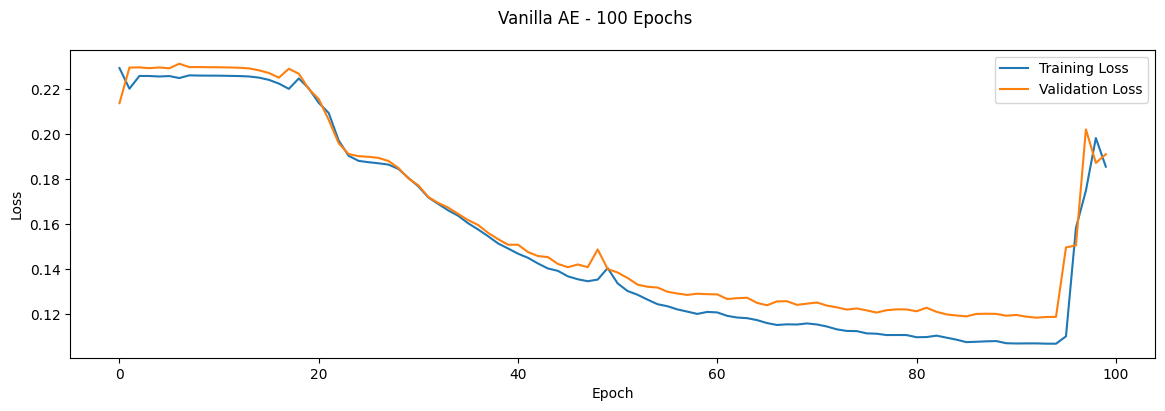

Best train_loss: 0.1068
Best val_loss: 0.1184
Last improvement of val_loss at epoch: 7


In [9]:
# plot the training history
plot_history(comment=config.comment, history=history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


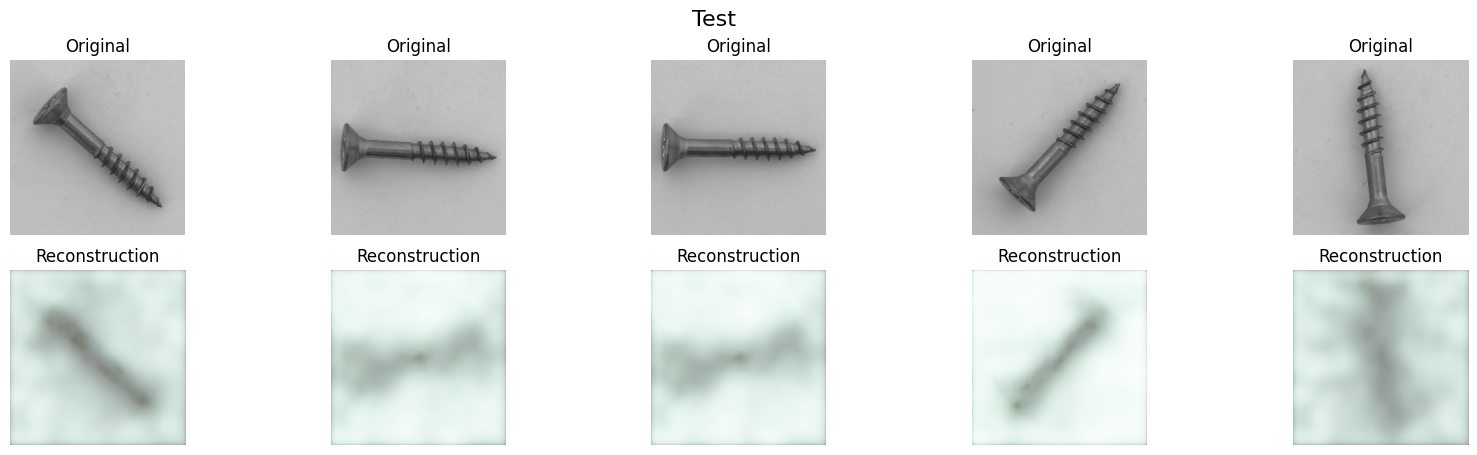

In [10]:
plot_reconstructions(autoencoder, test_generator, n_images=5, title='Test')


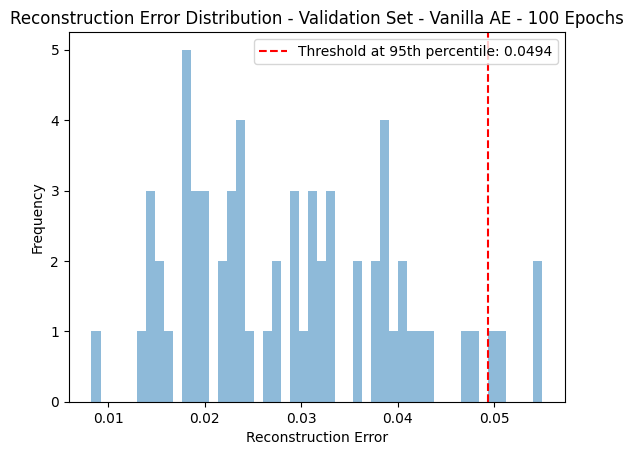

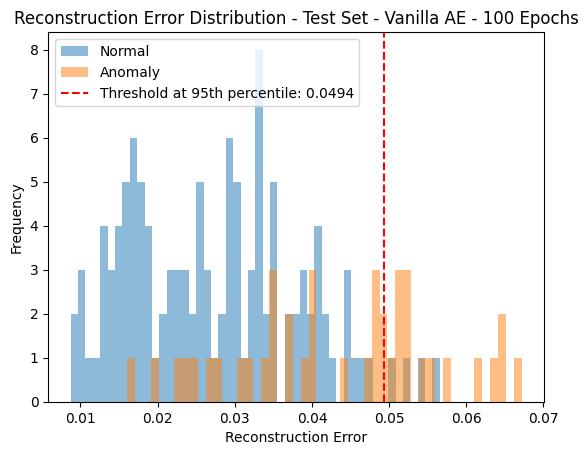

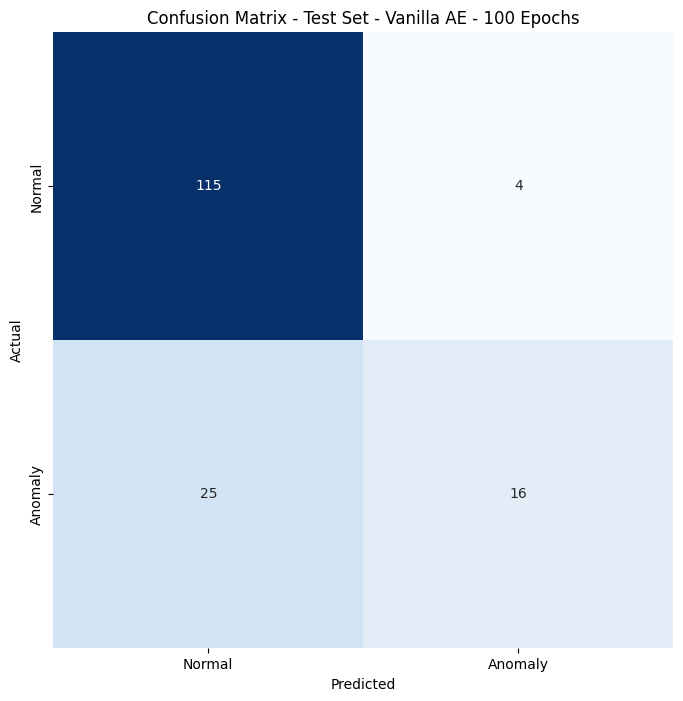

In [11]:
evaluate_autoencoder(
    config = config,
    autoencoder=autoencoder,
    validation_generator=validation_generator,
    test_generator=test_generator
    )

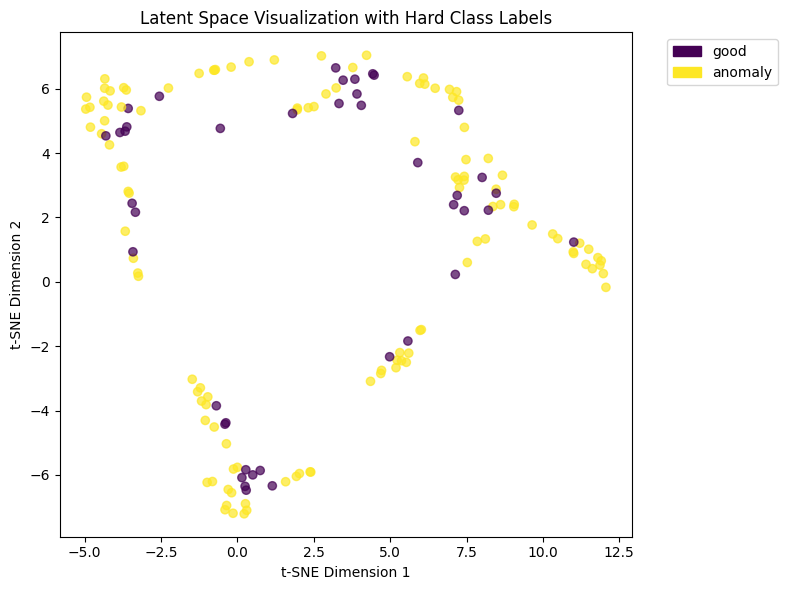

In [12]:
plot_latent_space(autoencoder, test_generator, layer_name='dense')